In [ ]:
import pandas as pd
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


df = pd.read_csv(r"Real_Data\primaryschool.csv", sep="\t", header=None)

merged = defaultdict(set)

for node_col, attr_col in [(1, 3), (2, 4)]:
    for node, attrs in df.groupby(node_col)[attr_col]:
        merged[node].update(attrs)

meta_df = (
    pd.DataFrame(
        [(node, next(iter(attrs))) for node, attrs in merged.items()],
        columns=["node", "attribute"],
    )
    .sort_values("attribute")
    .reset_index(drop=True)
)

node_mapping = dict(zip(meta_df["node"], meta_df.index))
node_to_attribute = dict(zip(meta_df.index, meta_df["attribute"]))

df = df[[0, 1, 2]]
df.columns = ["starting_times", "source_nodes", "target_nodes"]

df["source_nodes"] = df["source_nodes"].map(node_mapping)
df["target_nodes"] = df["target_nodes"].map(node_mapping)


MIN_TIME = 8.5 * 3600
df["starting_times"] = df["starting_times"] - MIN_TIME
df = df[df["starting_times"] > 24 * 3600].reset_index(drop=True)
df["starting_times"] = df["starting_times"] - 24 * 3600
df['starting_times']=df['starting_times']-df['starting_times'].min()
df["ending_times"] = df["starting_times"] + 20
df['durations']=df["ending_times"] -df["starting_times"] 
df['source_nodes']=df['source_nodes'].astype(int)
df['target_nodes']=df['target_nodes'].astype(int)

df['ending_times']=df['ending_times'].astype(int)
df['starting_times']=df['starting_times'].astype(int)
df['durations']=df['durations'].astype(int)

df['source_nodes']=df['source_nodes'].map(mapping)
df['target_nodes']=df['target_nodes'].map(mapping)

df.to_csv('Pre_processed_Data\primary_school_day2.csv', index=False)

In [63]:
missing = {121, 172, 207, 213}
all_nodes = list(range(242))  # 1 to 242 inclusive
present_nodes = [n for n in all_nodes if n not in missing]

# Map each present node to a new continuous label starting from 0
mapping = {old: new for new, old in enumerate(present_nodes)}


meta_df.reset_index(names='node_name', inplace=True)
class_mapping={mapping.get(meta_df.iloc[i]['node_name'], 'unknown'):meta_df.iloc[i]['attribute'] for i in range(len(meta_df))}
del class_mapping['unknown']
np.save('Pre_processed_Data/mapping_dict.npy', class_mapping)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_10556\3284339952.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(classes))


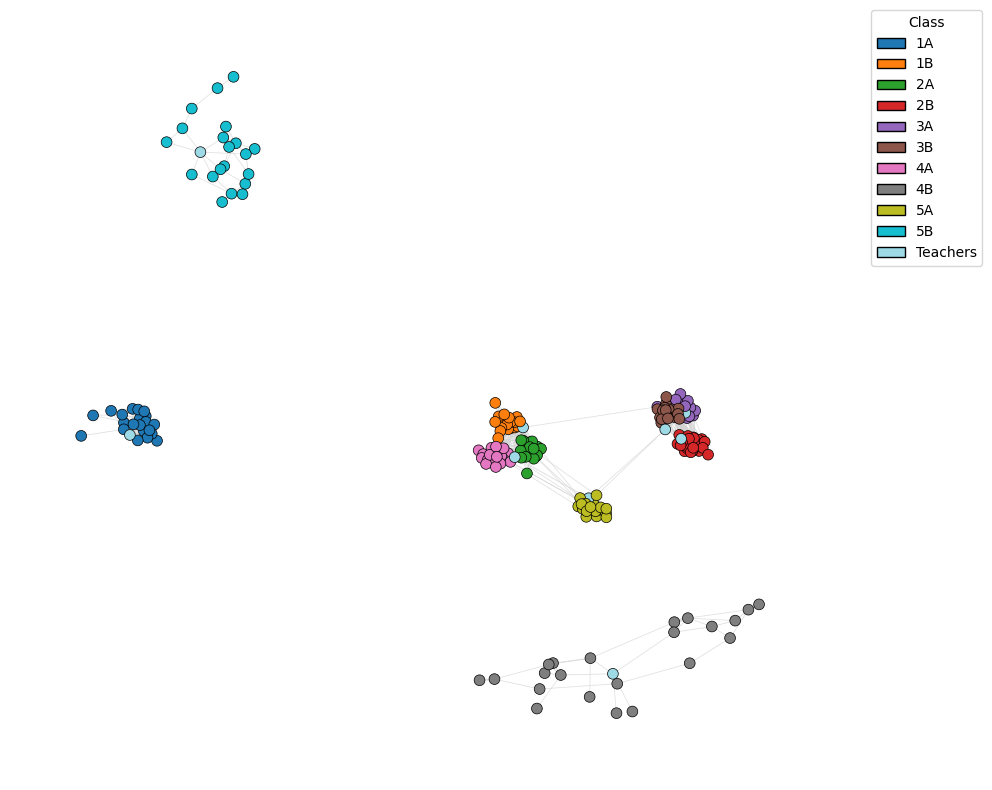

In [90]:
t=1
new_df=df[(df['starting_times']> t *3600)&(df['starting_times']<= (t+1) *3600)]
static=new_df.groupby(['source_nodes', 'target_nodes'])['starting_times'].count().reset_index().rename(columns={'starting_times':'weight'})


G = nx.Graph()
for _, row in static.iterrows():
    G.add_edge(
        int(row["source_nodes"]),
        int(row["target_nodes"]),
        weight=float(row["weight"])
    )




# G is your graph
# node_to_class: dict mapping node -> class label
node_to_class =class_mapping

# 1. Choose a layout
pos = nx.spring_layout(G, seed=42)   # or kamada_kawai_layout(G)

# 2. Get unique classes and map to colors
classes = sorted(set(node_to_class[n] for n in G.nodes()))
class_to_color = {c: i for i, c in enumerate(classes)}

# Use a colormap (e.g. tab20 for many discrete classes)
cmap = plt.cm.get_cmap("tab20", len(classes))

node_colors = [
    cmap(class_to_color[node_to_class[n]])
    for n in G.nodes()
]

# 3. Edge widths based on weight
edge_weights = [G[u][v].get("weight", 1) for u, v in G.edges()]
# Normalize widths a bit
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [0.5 + 3 * (w / max_w) for w in edge_weights]

plt.figure(figsize=(10, 8))

# 4. Draw edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color="lightgray",
    alpha=0.7,
    arrows=False  # set True if directed and you want arrows
)

# 5. Draw nodes colored by class
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=60,
    linewidths=0.5,
    edgecolors="black"
)

plt.axis("off")

# 6. Add legend for classes
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=cmap(class_to_color[c]), edgecolor="black", label=str(c))
    for c in classes
]
plt.legend(
    handles=legend_handles,
    title="Class",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()



C:\Users\Yasaman\AppData\Local\Temp\ipykernel_10556\3806535197.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(classes))


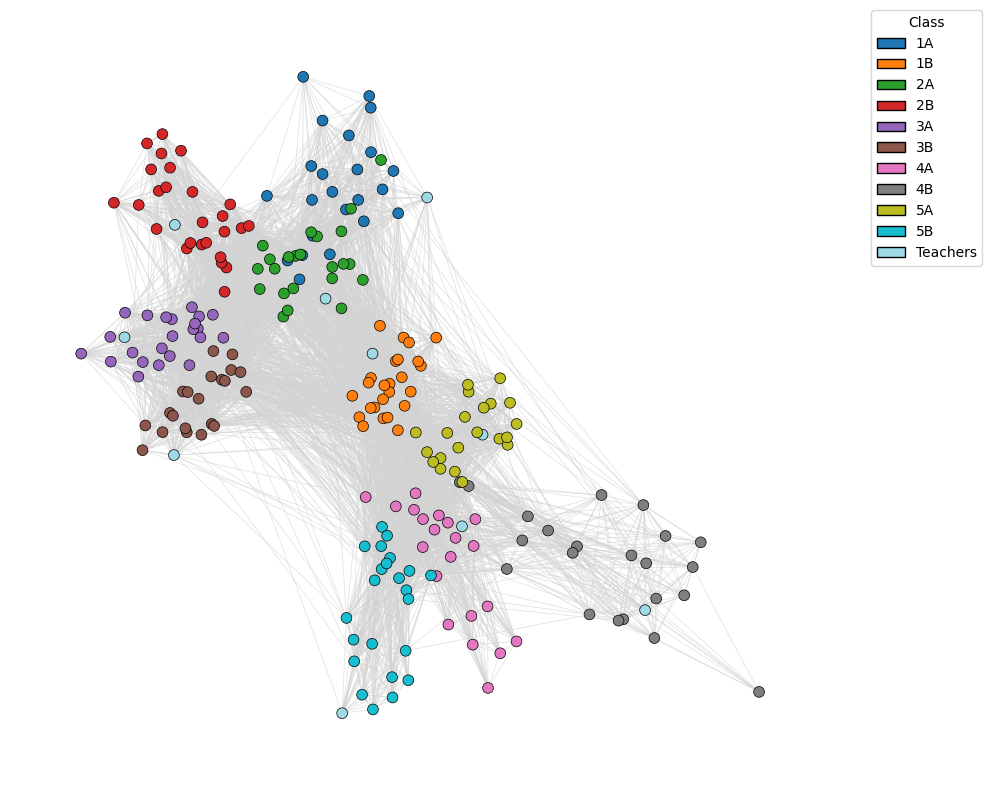